Chi-squared for Candidate 0: 138.1088069588234
Reduced Chi-squared for Candidate 0: 46.03626898627447
Modulation index for Candidate 0: 76.39899023233252%


/tmp/ipykernel_8184/4157964128.py:44: RuntimeWarning: invalid value encountered in arccos
  np.arccos(np.sin(np.radians(dec_i)) * np.sin(np.radians(dec_j)) +


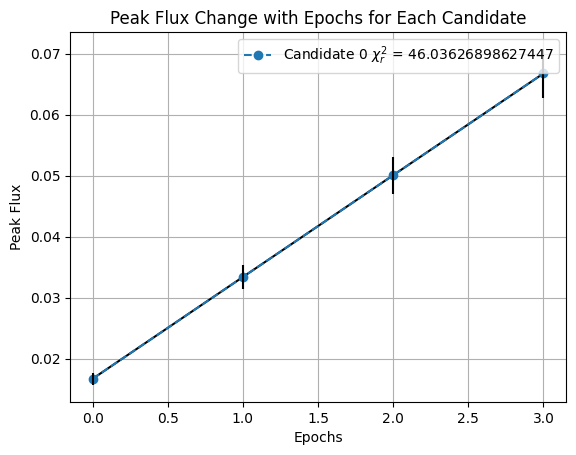

Chi-squared for Candidate 1: 1447.561811583158
Reduced Chi-squared for Candidate 1: 482.5206038610527
Modulation index for Candidate 1: 92.75642327730301%


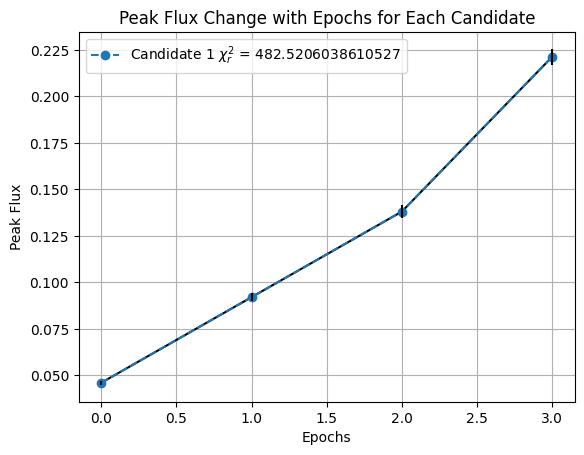

Chi-squared for Candidate 2: 794.6999466046511
Reduced Chi-squared for Candidate 2: 264.89998220155036
Modulation index for Candidate 2: 139.4977632564886%


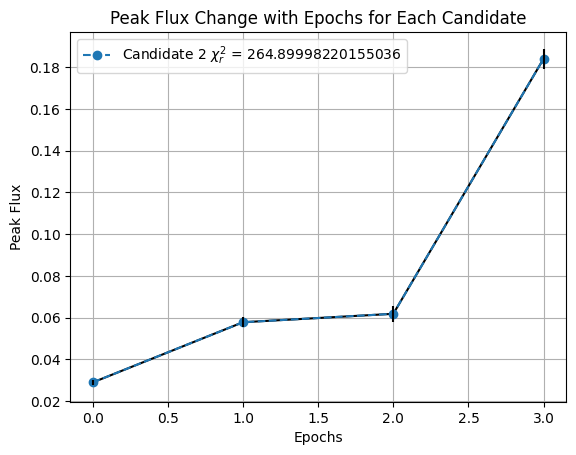

Chi-squared for Candidate 3: 202.5023705397461
Reduced Chi-squared for Candidate 3: 67.50079017991537
Modulation index for Candidate 3: 29.850266377289554%


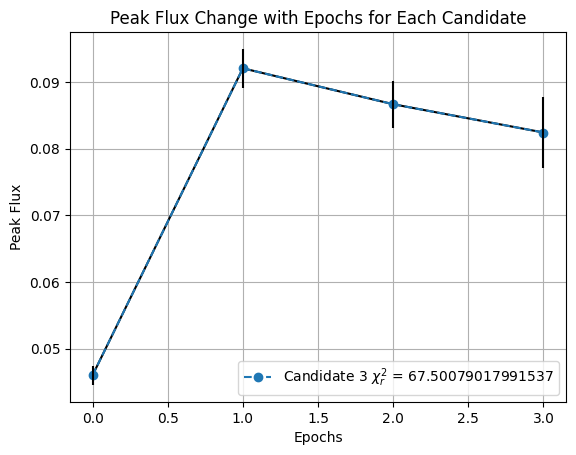

Chi-squared for Candidate 4: 593.377457547563
Reduced Chi-squared for Candidate 4: 197.79248584918767
Modulation index for Candidate 4: 50.056714577553386%


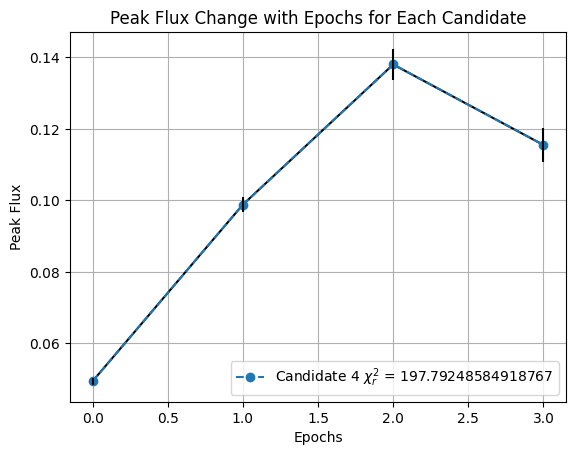

Chi-squared for Candidate 5: 1499.598716327606
Reduced Chi-squared for Candidate 5: 499.8662387758687
Modulation index for Candidate 5: 208.051441782292%


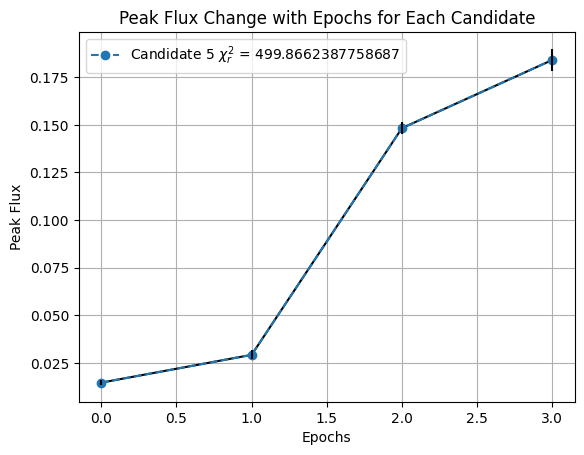

Chi-squared for Candidate 6: 1179.3444583079213
Reduced Chi-squared for Candidate 6: 393.11481943597374
Modulation index for Candidate 6: 62.11792064650541%


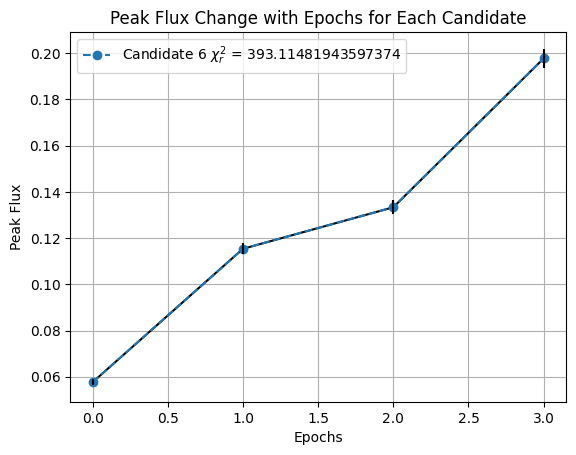

In [6]:
import pandas as pd
import numpy as np

# Load all pulsar candidate files for n days into a list of DataFrames #Remember to change the SIBF to get  MJD in candidate name file. 
n_epochs = 4  # Change this to the actual number of days/MJD
candidates =[]
# Move the list initialization outside the outer loop
peak_flux_values = []
e_peak_flux_values = []
rms_local_values = []

for epoch in range(n_epochs):
    filename = f'Pulsar_candidates_G033.0-5.0_{epoch+1}.csv' # this should work for observed sources as well ! need to check 
    candidates.append(pd.read_csv(filename))

#print(candidates)

matched_sources = []

# loop each day
for j in range(1, n_epochs):
    candidates_day_1 = candidates[0]
    candidates_day_j = candidates[j]


    for idx_i in range(len(candidates_day_1)):
        ra_i = candidates_day_1[' RA'][idx_i]
        dec_i = candidates_day_1[' DEC'][idx_i]
        source_mask_i = (candidates_day_1[' Maj'][idx_i] + candidates_day_1[' Min'][idx_i])/2  # source size in degrees visuslly confirmed on ds9

        match_found = False

        for idx_j in range(len(candidates_day_j)):  # loop through each source in candidates_day_j
            ra_j = candidates_day_j[' RA'][idx_j]
            dec_j =candidates_day_j[' DEC'][idx_j]

            # the angular separation between the two sources (with day_1 only)
            if ra_i == ra_j and dec_i == dec_j:
                theta =0.0
            else:
                theta = np.degrees(
                    np.arccos(np.sin(np.radians(dec_i))*np.sin(np.radians(dec_j)) +np.cos(np.radians(dec_i)) *np.cos(np.radians(dec_j)) * np.cos(np.radians(ra_i -ra_j))))

            # if the angular separation is within the constraint
            if abs(theta) <= source_mask_i:
                sources_data = []

                for day_idx in range(n_epochs):
                    day_candidates = candidates[day_idx]
                    source_idx = (idx_i, idx_j)[day_idx == j]  # Choose the correct source index based on the day
                    ra = day_candidates[' RA'][source_idx]
                    dec = day_candidates[' DEC'][source_idx]
                    peak_flux = day_candidates[' Peak_flux'][source_idx]
                    e_peak_flux = day_candidates[' E_Peak_flux'][source_idx]
                    rms_l = day_candidates[' Isl_rms'][source_idx]
                    sources_data.extend([ra, dec, peak_flux, e_peak_flux, rms_l])

                    peak_flux_values.append(peak_flux)
                    e_peak_flux_values.append(e_peak_flux)
                    rms_local_values.append(rms_l)

                
                match_found = True
                break   #match is found

        if match_found:
            matched_sources.append(sources_data)

columns = []
for day_idx in range(n_epochs):
    day_prefix = f'epoch_{day_idx + 1}'
    for param in ['RA', 'DEC', 'Peak_flux', 'E_Peak_flux', 'Isl_rms']:
        columns.append(f'{day_prefix}_{param}')

matched_sources_df = pd.DataFrame(matched_sources, columns=columns)


num_candidates = len(candidates_day_1)
peak_flux = {}
e_peak_flux={}
Isl_rms = {}
for j in range(num_candidates):
    candidate_peak_flux_j = []
    candidate_e_peak_flux_j = []
    candidate_Isl_rms_j = []
    

    for candidate_idx in range(num_candidates):
        start_index = j *n_epochs
        end_index = start_index + n_epochs
        
        candidate_peak_flux = peak_flux_values[start_index:end_index:1]
        candidate_e_peak_flux = e_peak_flux_values[start_index:end_index:1]
        candidate_rms = rms_local_values[start_index:end_index:1]

    candidate_peak_flux_j.append(candidate_peak_flux)
    candidate_e_peak_flux_j.append(candidate_e_peak_flux)
    candidate_Isl_rms_j.append(candidate_rms)

    #print(candidate_peak_flux_j) print out statement 

    peak_flux[f'candidate_{j}'] = candidate_peak_flux_j
    e_peak_flux[f'candidate_{j}'] = candidate_e_peak_flux_j
    Isl_rms[f'candidate_{j}'] = candidate_Isl_rms_j

import matplotlib.pyplot as plt

#array of epochs(This can be altered depending on the observations)
epochs = np.arange(n_epochs)
rms_bkg = [] #global rms fluctuation in image with epoch (This needs clarification)
#through candidates 
for j in range(num_candidates):
    # store the values 
    candidate_peak_flux = peak_flux[f'candidate_{j}'][0]
    candidate_e_peak_flux = e_peak_flux[f'candidate_{j}'][0]
    candidate_rms_l = Isl_rms[f'candidate_{j}'][0]
  
    # variability statistics (check formula #1)
    sbar = np.sum(np.array(candidate_peak_flux) /np.array(candidate_rms_l) **2) / np.sum(1/ np.array(candidate_rms_l)** 2)
    # for global variability replace rms_l with rms_bkg (this needs clarification)
    std_deviation = np.std(candidate_peak_flux)

    #chi-squared 
    chi_squared = np.sum(((np.array(candidate_peak_flux) - sbar) / np.array(candidate_rms_l)) ** 2)

    #degrees of freedom
    degrees_of_freedom = len(candidate_peak_flux) - 1 

    #reduced chi-squared
    chi_sq_r = chi_squared / degrees_of_freedom
    mod_index = std_deviation/sbar
    

    print(f"Chi-squared for Candidate {j}: {chi_squared}")
    print(f"Reduced Chi-squared for Candidate {j}: {chi_sq_r}")
    print(f"Modulation index for Candidate {j}: {mod_index*100}%")
    
# peak_flux vs epochs for the current candidate
    plt.plot(epochs, candidate_peak_flux, marker='o',linestyle = '--',label=f'Candidate {j} $\\chi^2_r$ = {chi_sq_r}')
    plt.errorbar(epochs, candidate_peak_flux,yerr=candidate_e_peak_flux,color = 'black',barsabove=True)
    plt.xlabel('Epochs')
    plt.ylabel('Peak Flux')
    plt.title('Peak Flux Change with Epochs for Each Candidate')
    plt.legend()
    plt.grid()
    plt.show()